# Initialization & Setup

In [336]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from google.colab import drive
from tqdm import tqdm

In [337]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [338]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}\n")

Device is: cuda



In [339]:
data_path = '/content/drive/MyDrive/biomedicine/embedded_data/'

# Hyper- and Controlparameter

In [340]:
# Controlparameter

LOAD_FROM_DRIVE = False
SAVE_TO_DRIVE = True

In [341]:
# HYPERPARAMETER

BATCH_SIZE = 128
LEARNING_RATE = 0.0001
NUM_EPOCHS = 10

# Custom Dataset & Data Preparation

In [342]:
label_map = {
    'control': 0,
    'mild/moderate': 1,
    'severe/critical': 2,
    'progression': 1,
    'convalescence': 2,
}

In [343]:
class EmbeddedDataset(Dataset):
    def __init__(self, pkl_file, minimum=0, n_samples=0):
        self.data = pd.read_pickle(pkl_file)
        self.minimum = minimum
        self.downsample_labels()


        unique_labels = pd.unique(self.data['severity'])
        celltypes = pd.unique(self.data['celltype'])
        # print(f"unique cell types: {cell_types}")
        label_counts = {}
        for label in self.data['severity']:
            label_counts[label] = label_counts.get(label, 0) + 1
        print(f"unique labels: {unique_labels}")
        print(f"label counts: {label_counts}")
        print(self.data.head())
        if minimum != 0:
            self.enforce_minimum()
            if n_samples > 0:
                self.enforce_number_of_samples(n_samples, self.minimum)
                self.find_equal_distribution_with_number_of_samples(len(self.cell_types_list()), n_samples)
            else:
                print("Implement minimum again")
        elif n_samples > 0:
            raise Exception("Illegal to specify number of samples without a minimum. How are we supposed to know what kind of distribution you want?")

    def cell_types_list(self):
        return list(pd.unique(self.data['celltype']))
    def distribution_cell_types(self):
        return self.data['celltype'].value_counts()

    def find_equal_distribution_with_number_of_samples(self, n_celltypes, n_samples):
        """Recursively finds a fitting distribution for the specified number of samples and minimum number of samples per celltype"""
        if n_celltypes == 0:
            raise Exception(f"Could not find a valid data distribution for your combination of n_samples ({n_samples}) and minimum ({self.minimum}). \n Consider decreasing one or both of them to get a valid distribution.")
        nth_celltype_count = self.distribution_cell_types().iloc[n_celltypes-1]
        if(nth_celltype_count * n_celltypes > n_samples):
            self.downsample_celltypes(n_celltypes, n_samples)
        else:
            self.find_equal_distribution_with_number_of_samples(n_celltypes-1, n_samples)

    def enforce_minimum(self):
        """Cut all celltypes that does not have at least minimum samples"""
        minimum_fulfilling_celltypes = self.distribution_cell_types()[self.distribution_cell_types() >= self.minimum].index
        self.data = self.data[self.data['celltype'].isin(minimum_fulfilling_celltypes)]

    def enforce_number_of_samples(self, n_samples, minimum):
        """Truncate the celltypes to a number of celltypes that suffice to reach the number of samples, while providing the minimum number of samples per celltype.
        Always prefer celltypes with more counts over celltypes with less counts."""
        n_celltypes = min((n_samples // minimum), len(self.cell_types_list()))
        self.data = self.data[self.data['celltype'].isin(self.distribution_cell_types().iloc[:n_celltypes].index)]

    def downsample_labels(self):
        """Downsamples the data to achieve equal label distribution for severity within each cell type"""
        cell_types = self.cell_types_list()
        downsampled_data = pd.DataFrame()
        for cell_type in cell_types:
            cell_type_data = self.data[self.data['celltype'] == cell_type]
            label_counts = cell_type_data['severity'].value_counts()
            min_count = label_counts.min()
            sampled_data = pd.DataFrame()
            for label in label_counts.index:
                label_data = cell_type_data[cell_type_data['severity'] == label]
                sampled_label_data = label_data.sample(n=min_count, random_state=42)
                sampled_data = pd.concat([sampled_data, sampled_label_data])
            downsampled_data = pd.concat([downsampled_data, sampled_data])
        self.data = downsampled_data

    def downsample_celltypes(self, n_celltypes, n_samples):
        """Downsamples the data to achieve equal celltype distribution while providing the specified number of total samples"""
        n = n_samples // n_celltypes
        difference = n_samples - (n * n_celltypes)
        valid_celltypes = self.distribution_cell_types().iloc[:n_celltypes].index
        downsampled_data = pd.DataFrame()
        for i, cell_type in enumerate(valid_celltypes):
            cell_type_data = self.data[self.data['celltype'] == cell_type]
            if i < difference:
                sampled_data = cell_type_data.sample(n=n+1, random_state=42)
            else:
                sampled_data = cell_type_data.sample(n=n, random_state=42)
            downsampled_data = pd.concat([downsampled_data, sampled_data])
        self.data = downsampled_data
        sample_sum = sum([x for x in self.data['celltype'].value_counts().values])
        print(f"\nSum of samples: {sample_sum}")
        print(f"Number of celltypes: {len(self.data['celltype'].value_counts())}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embeddings = torch.tensor(self.data.iloc[idx, 0], dtype=torch.float32)
        label_state = torch.tensor(label_map.get(self.data.iloc[idx, 1]), dtype=torch.long)
        label_severity = torch.tensor(label_map.get(self.data.iloc[idx, 3]), dtype=torch.long)
        cell_type = self.data.iloc[idx, 2]

        return embeddings, label_severity, label_state, cell_type

## Data Distribution

In [344]:
TOTAL_NUMBER_OF_SAMPLES = 60 * 1000
MINIMUM_NUMBER_OF_SAMPLES_PER_CELLTYPE = 15 * 1000

In [345]:
dataset = EmbeddedDataset(os.path.join(data_path, 'embedded_data_split_severity_celltype_progression_all.pkl'),MINIMUM_NUMBER_OF_SAMPLES_PER_CELLTYPE,TOTAL_NUMBER_OF_SAMPLES)


unique labels: ['severe/critical' 'mild/moderate' 'control']
label counts: {'severe/critical': 166047, 'mild/moderate': 166005, 'control': 164256}
                                                embeddings         severity  \
1426289  [0.045433894, -0.0043206816, -0.008506793, -0....  severe/critical   
234867   [0.036496725, -0.009099111, -0.019840367, -0.0...  severe/critical   
822203   [0.040514573, -0.0162694, -0.008460669, 0.0049...  severe/critical   
234348   [0.04210682, -0.023745155, -0.01684023, -0.013...  severe/critical   
1291850  [0.03699777, -0.0076743234, -0.0266033, -0.014...  severe/critical   

                      celltype    Sample time  
1426289  Mono_c2-CD14-HLA-DPB1  convalescence  
234867   Mono_c2-CD14-HLA-DPB1  convalescence  
822203   Mono_c2-CD14-HLA-DPB1  convalescence  
234348   Mono_c2-CD14-HLA-DPB1  convalescence  
1291850  Mono_c2-CD14-HLA-DPB1    progression  

Sum of samples: 60000
Number of celltypes: 4


In [346]:
dataset.distribution_cell_types()

,count
celltype,
T_CD4_c01-LEF1,15000
T_CD8_c01-LEF1,15000
Mono_c3-CD14-VCAN,15000
T_CD8_c05-ZNF683,15000


In [347]:
print(f"Number of different celltypes: {len(dataset.cell_types_list())}")

Number of different celltypes: 4


In [348]:
# total_count = 0
# for i, (celltype, count) in enumerate(dataset.distribution_cell_types().items()):
#   total_count += count
#   print(f"{i:3} {celltype:28} {count} {total_count:7}")

In [349]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [350]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [351]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [352]:
for (embeddings, labels_severity,labels_state,_) in train_loader:
    print(type(embeddings[0]))
    print(type(labels_severity[0]))
    print(type(embeddings[0][0]))
    print(type(labels_severity[0].item()))
    print(type(labels_state[0].item()))
    print(labels_severity)
    print(labels_state)
    break

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'int'>
<class 'int'>
tensor([0, 1, 1, 1, 1, 0, 2, 1, 2, 2, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2,
        0, 2, 2, 2, 0, 1, 2, 1, 1, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 2, 1, 0,
        2, 1, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 2, 2, 2, 0, 0, 1, 0, 1, 0, 0, 0, 2,
        0, 0, 1, 2, 1, 0, 1, 2, 0, 2, 0, 2, 0, 2, 1, 2, 2, 1, 2, 2, 0, 2, 1, 2,
        1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 2, 1, 0, 0, 2, 1, 1, 0, 0,
        2, 2, 2, 1, 0, 2, 2, 0])
tensor([0, 1, 2, 2, 1, 0, 1, 2, 2, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 2,
        0, 2, 1, 1, 0, 2, 1, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 1, 1, 0,
        1, 2, 2, 1, 2, 0, 2, 2, 0, 0, 2, 0, 2, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 2, 2, 1, 0, 2, 2, 0, 1, 0, 1, 0, 1, 2, 1, 1, 2, 1, 1, 0, 1, 2, 1,
        2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0,
        2, 2, 1, 2, 0, 1, 2, 0])


# Model Architecture


In [353]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=1024),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=1024, out_features=2048),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=2048, out_features=2048),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=2048, out_features=1024),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=1024, out_features=1024),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=1024, out_features=3),
        )

    def forward(self, x):
        return self.layers(x)

In [354]:
# Training Loop
def train(model, train_loader, num_epochs, optimizer, criterion):
    model.to(device)  # Move model to device ONCE
    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        dataloader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, (embeddings, severity_labels, state_labels, celltype) in enumerate(dataloader):
            embeddings = embeddings.to(device)
            severity_labels = severity_labels.to(device).long()  # Labels: 0=Control, 1=Mild, 2=Severe
            state_labels = state_labels.to(device).long()  # Labels: 0=Control, 1=Progression, 2=Convalescence

            optimizer.zero_grad()
            output = model(embeddings)  # Get raw logits

            loss = criterion(output, severity_labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            dataloader.set_postfix({"Loss": running_loss / (i + 1)})  # Show average loss per batch


In [355]:
# directory paths to google drive for model saving and retrieving

directory_path = 'content/MyDrive/biomedicine/models/classifier'

model_path = os.path.join(directory_path, f"classifier_model_{TOTAL_NUMBER_OF_SAMPLES}_{TOTAL_NUMBER_OF_SAMPLES}.pth")

print(model_path)

content/MyDrive/biomedicine/models/classifier/classifier_model_60000_60000.pth


In [356]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 1/m.weight.shape[1])

In [357]:
# Initialize the model

model = Classifier().to(device)

if LOAD_FROM_DRIVE:
    try:
        model.load_state_dict(torch.load(model_path, weights_only=True))
        print("Model loaded from drive")
    except Exception as e:
        print(f"Error loading model from drive: {e}")
# else:
#     model.apply(weights_init)

# set up loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training

In [358]:
# start training loop
if not LOAD_FROM_DRIVE:
    train(
        model=model,
        train_loader=train_loader,
        num_epochs=NUM_EPOCHS,
        optimizer=optimizer,
        criterion=criterion
    )

Epoch 10/10: 100%|██████████| 375/375 [00:10<00:00, 37.20it/s, Loss=0.253]


In [359]:
# save to drive

if SAVE_TO_DRIVE:
    try:
        os.makedirs(directory_path)
    except FileExistsError:
        pass

    torch.save(model.state_dict(), model_path)
    print("Model saved to drive")

Model saved to drive


# Evaluation

In [360]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import defaultdict
import numpy as np

def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    cell_type_results = defaultdict(lambda: {"y_true": [], "y_pred": []})  # Store results per cell type

    with torch.no_grad():
        for embeddings, severity_labels, state_labels, cell_types in test_loader:
            embeddings = embeddings.to(device)
            severity_labels = severity_labels.to(device).long()  # Labels: 0=Control, 1=Mild, 2=Severe
            state_labels = state_labels.to(device).long()  # Labels: 0=Control, 1=Progression, 2=Convalescence
            labels = severity_labels # change depending on which output you want to evaluate

            outputs = model(embeddings).squeeze()
            preds = torch.argmax(outputs, dim=1)  # Convert probabilities to predicted labels

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Store results for each cell type
            for i, cell in enumerate(cell_types):
                cell_type_results[cell]["y_true"].append(labels[i].item())
                cell_type_results[cell]["y_pred"].append(preds[i].item())

    # Compute overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=["control", "mild/moderate", "severe/critical"], yticklabels=["control", "mild/moderate", "severe/critical"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute metrics per cell type
    cell_type_list, acc_list, f1_list, prec_list, rec_list = [], [], [], [], []
    for cell, values in cell_type_results.items():
        acc = accuracy_score(values["y_true"], values["y_pred"])
        prec = precision_score(values["y_true"], values["y_pred"], average="macro")
        rec = recall_score(values["y_true"], values["y_pred"], average="macro")
        f1 = f1_score(values["y_true"], values["y_pred"], average="macro")

        cell_type_list.append(cell)
        acc_list.append(acc)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)

    cell_type_results_df = pd.DataFrame({
        "Cell Type": cell_type_list,
        "Accuracy": acc_list,
        "F1-score": f1_list,
        "Precision": prec_list,
        "Recall": rec_list
    })

    return accuracy, precision, recall, f1, cell_type_results_df


In [361]:
import pandas as pd
from collections import Counter

def compare_cell_type_distribution(dataset, train_loader, test_loader):
    # Get total distribution from dataset (assuming it's a DataFrame)
    total_distribution = dataset.distribution_cell_types()

    # Ensure it's a DataFrame
    if isinstance(total_distribution, pd.Series):
        total_distribution = total_distribution.reset_index()
        total_distribution.columns = ["Cell Type", "Total Count"]

    # Initialize counters for train and test sets
    train_counter = Counter()
    test_counter = Counter()

    # Count occurrences of each cell type in training set
    for _, _, _, cell_types in train_loader:
        train_counter.update(cell_types)

    # Count occurrences of each cell type in test set
    for _, _, _, cell_types in test_loader:
        test_counter.update(cell_types)

    # Convert counters to Pandas Series
    train_series = pd.Series(train_counter, name="Train Count")
    test_series = pd.Series(test_counter, name="Test Count")

    # Create a DataFrame with all distributions
    df = total_distribution.set_index("Cell Type").join([train_series, test_series]).fillna(0)

    # Convert counts to integers
    df = df.astype(int)

    # Print the table
   # print(df)

    return df


In [362]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def analyze_correlation(dataset, train_loader, test_loader, model):
    # Step 1: Get dataset distribution
    total_distribution = dataset.distribution_cell_types()

    # Ensure it's a DataFrame
    if isinstance(total_distribution, pd.Series):
        total_distribution = total_distribution.reset_index()
        total_distribution.columns = ["Cell Type", "Train Count"]

    # Step 2: Evaluate model performance per cell type
    _, _, _, _, cell_results = evaluate(model, test_loader)
    """
    # Step 3: Ensure cell_results is properly structured
    if isinstance(cell_results, dict):
        performance_data = []
        for cell_type, metrics in cell_results.items():
            if isinstance(metrics, dict):  # Ensure it's not a string or number
                row = {"Cell Type": cell_type}
                row.update(metrics)  # Add accuracy, F1-score, etc.
                performance_data.append(row)
        performance_df = pd.DataFrame(performance_data)
    else:
        raise ValueError("cell_results is not a valid dictionary.")
    """
    # Step 4: Merge both DataFrames
    merged_df = total_distribution.merge(cell_results, on="Cell Type", how="inner")

    # Step 5: Compute correlation
    correlation_results = {
        "Accuracy": pearsonr(merged_df["Train Count"], merged_df["Accuracy"])[0],
        "F1-score": pearsonr(merged_df["Train Count"], merged_df["F1-score"])[0]
    }

    # Step 6: Visualization
    plt.figure(figsize=(12, 5))

    # Scatter Plot: Frequency vs Accuracy
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=merged_df["Train Count"], y=merged_df["Accuracy"])
    plt.xlabel("Train Count of Cell Type")
    plt.ylabel("Accuracy")
    plt.title(f"Correlation: {correlation_results['Accuracy']:.4f}")

    # Scatter Plot: Frequency vs F1-score
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=merged_df["Train Count"], y=merged_df["F1-score"])
    plt.xlabel("Train Count of Cell Type")
    plt.ylabel("F1-score")
    plt.title(f"Correlation: {correlation_results['F1-score']:.4f}")

    plt.tight_layout()
    plt.show()

    # Print correlation results
    print("Correlation between Cell Type Frequency and Performance:")
    print(f"  Accuracy Correlation: {correlation_results['Accuracy']:.4f}")
    print(f"  F1-score Correlation: {correlation_results['F1-score']:.4f}")

    return merged_df, correlation_results


In [363]:
# df_analysis, correlation = analyze_correlation(dataset, train_loader, test_loader, model)

## Results

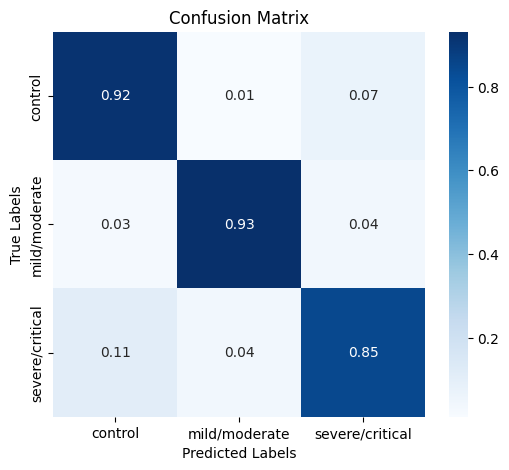

(0.8915,
 0.8934529945761791,
 0.8981914562714021,
 0.9245407056647249,
            Cell Type  Accuracy  F1-score  Precision    Recall
 0     T_CD4_c01-LEF1  0.895175  0.899581   0.896396  0.905041
 1     T_CD8_c01-LEF1  0.883470  0.888049   0.887192  0.890835
 2   T_CD8_c05-ZNF683  0.864856  0.866781   0.867165  0.868140
 3  Mono_c3-CD14-VCAN  0.922921  0.924541   0.923278  0.927019)

In [364]:
evaluate(model, test_loader)

In [365]:
compare_cell_type_distribution(dataset, train_loader, test_loader)


,Total Count,Train Count,Test Count
Cell Type,,,
T_CD4_c01-LEF1,15000,11995,3005
T_CD8_c01-LEF1,15000,11945,3055
Mono_c3-CD14-VCAN,15000,12042,2958
T_CD8_c05-ZNF683,15000,12018,2982
